In [8]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [9]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [10]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [11]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [12]:
# reflect an existing database into a new model

Base = automap_base()

# reflect the tables
Base.prepare(engine)

# Access your classes
Station = Base.classes.station
Measurement = Base.classes.measurement

In [13]:
# View all of the classes that automap found
classes = Base.classes.keys()
print(classes)

['measurement', 'station']


In [14]:
# Save references to each table
Station = Base.classes.station
Measurement = Base.classes.measurement


In [15]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [16]:
# Find the most recent date in the data set.

most_recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()

most_recent_date = dt.datetime.strptime(most_recent_date[0], '%Y-%m-%d')

print("The most recent date in the dataset is:", most_recent_date)


The most recent date in the dataset is: 2017-08-23 00:00:00


In [29]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
one_year_ago = most_recent_date - dt.timedelta(days=365)


# Perform a query to retrieve the data and precipitation scores
precipitation_data = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= one_year_ago).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
df = pd.DataFrame(precipitation_data, columns=["Date", "Precipitation"])

# Sort the dataframe by date
df = df.sort_values(by="Date")



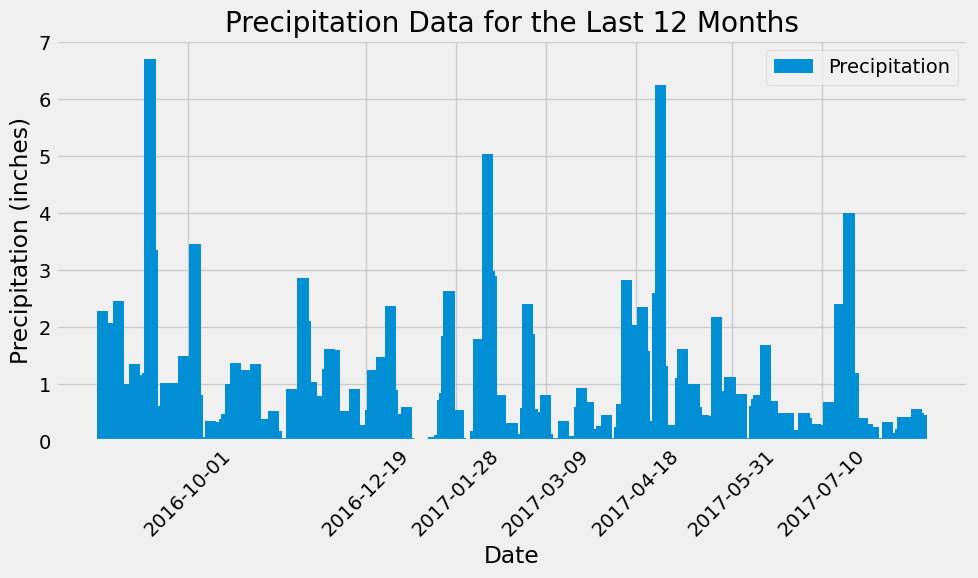

In [51]:
# Use Pandas Plotting with Matplotlib to plot the data
specified_date_labels = [
    "2016-10-01", "2016-12-19",
    "2017-01-28", "2017-03-09", "2017-04-18",
    "2017-05-31", "2017-07-10"
]

plt.figure(figsize=(10, 6))
plt.bar(df["Date"], df["Precipitation"], width=5, label="Precipitation")
plt.xlabel("Date")
plt.ylabel("Precipitation (inches)")
plt.title("Precipitation Data for the Last 12 Months")

tick_positions = range(len(specified_date_labels))

plt.xticks(specified_date_labels, rotation=45)

plt.legend()
plt.tight_layout()
plt.show()




In [52]:
# Use Pandas to calculate the summary statistics for the precipitation data

precipitation_stats = df["Precipitation"].describe()

print(precipitation_stats)



count    2015.000000
mean        0.176462
std         0.460288
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: Precipitation, dtype: float64


# Exploratory Station Analysis

In [54]:
# Design a query to calculate the total number of stations in the dataset
from sqlalchemy import distinct

total_stations = session.query(func.count(distinct(Station.station))).scalar()

print("Total Number of Stations:", total_stations)



Total Number of Stations: 9


In [55]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.

from sqlalchemy import func

active_stations = session.query(Measurement.station, func.count(Measurement.station)) \
    .group_by(Measurement.station) \
    .order_by(func.count(Measurement.station).desc()) \
    .all()

print("Most Active Stations:")
for station, count in active_stations:
    print(f"Station ID: {station}, Row Count: {count}")


Most Active Stations:
Station ID: USC00519281, Row Count: 2772
Station ID: USC00519397, Row Count: 2724
Station ID: USC00513117, Row Count: 2709
Station ID: USC00519523, Row Count: 2669
Station ID: USC00516128, Row Count: 2612
Station ID: USC00514830, Row Count: 2202
Station ID: USC00511918, Row Count: 1979
Station ID: USC00517948, Row Count: 1372
Station ID: USC00518838, Row Count: 511


In [57]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station = active_stations[0][0]

temperature_stats = session.query(
    func.min(Measurement.tobs).label("Lowest Temperature"),
    func.max(Measurement.tobs).label("Highest Temperature"),
    func.avg(Measurement.tobs).label("Average Temperature")
).filter(Measurement.station == most_active_station).all()

print("Temperature Statistics for the Most Active Station:")
for lowest, highest, average in temperature_stats:
    print(f"Lowest Temperature: {lowest} °F")
    print(f"Highest Temperature: {highest} °F")
    print(f"Average Temperature: {round(average, 2)} °F")


Temperature Statistics for the Most Active Station:
Lowest Temperature: 54.0 °F
Highest Temperature: 85.0 °F
Average Temperature: 71.66 °F


In [58]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
from datetime import datetime, timedelta

most_recent_date = session.query(func.max(Measurement.date)).scalar()
one_year_ago = datetime.strptime(most_recent_date, "%Y-%m-%d") - timedelta(days=365)

temperature_data = session.query(Measurement.date, Measurement.tobs) \
    .filter(Measurement.station == most_active_station) \
    .filter(Measurement.date >= one_year_ago) \
    .all()

temperature_df = pd.DataFrame(temperature_data, columns=["Date", "Temperature (°F)"])



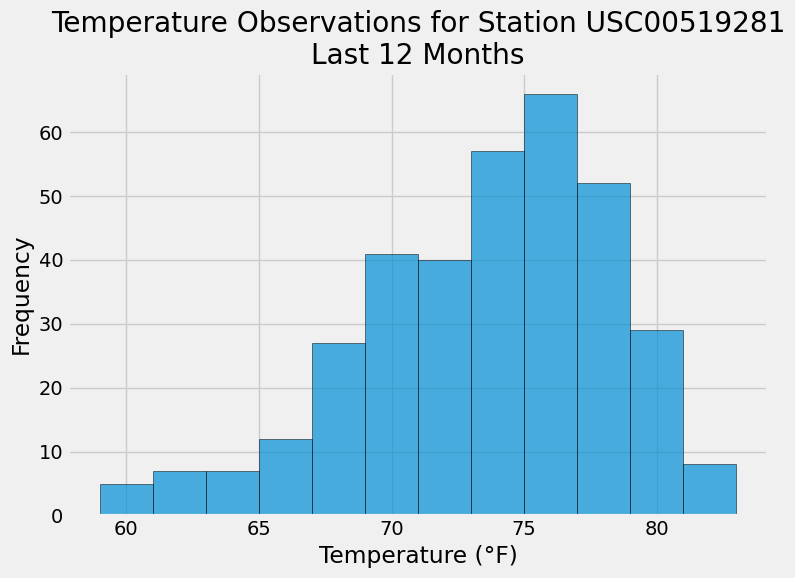

In [59]:
# Create a histogram to visualize the temperature observations
plt.figure(figsize=(8, 6))
plt.hist(temperature_df["Temperature (°F)"], bins=12, edgecolor='k', alpha=0.7)
plt.xlabel("Temperature (°F)")
plt.ylabel("Frequency")
plt.title(f"Temperature Observations for Station {most_active_station}\nLast 12 Months")
plt.tight_layout()
plt.show()


# Close Session

In [ ]:
# Close Session
session.close()